## Polynomial approximation- Lorenzo

## 1D

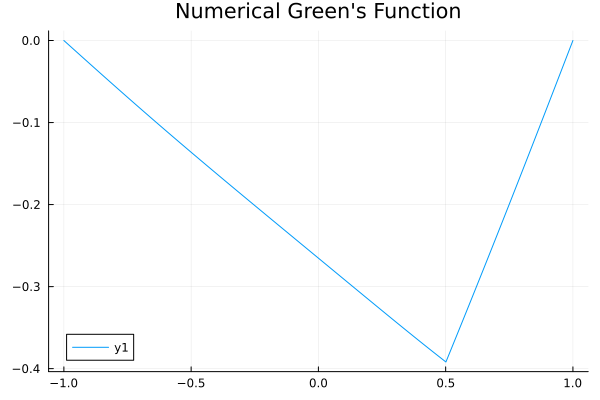

In [1]:
using LinearAlgebra
using Plots


function greens(n, y_spike) # gives a Green's Function for u'' + x^2 u = δ(x-y)
    h = step(x) # small value h
    Z = x[2:n].^2 # potential (coefficient of u)
    T = SymTridiagonal(ones(n-1).*(-2/h^2 .+ Z), ones(n-2)*1/h^2) # FD matrix
    y = y_spike # location of spike
    f = zeros(n-1) # initialize f
    i_y = argmin(abs.(x.-y)) # closest sampled point to the spike
    f[i_y] = 1/h # spike approximating δ
    u = T \ f # solve Tu = f
    return [0; u; 0]
end
n = 2000
x = range(-1, 1; length = n+1)
plot(x, greens(n, 0.5), title = "Numerical Green's Function")

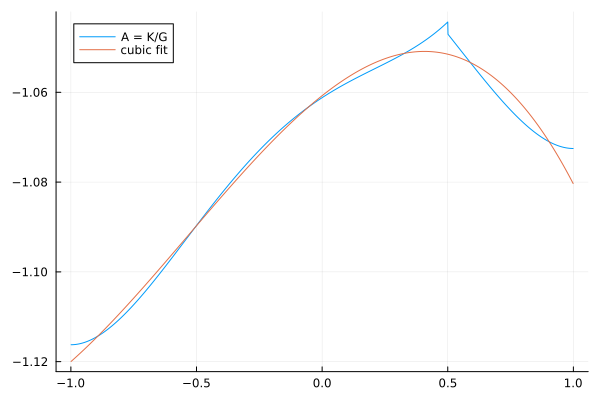

In [2]:
using LinearAlgebra, Plots

# Compute the numerical Green's function for fixed y=0.5 : JUST A SLICE
n = 2000
K_full = greens(n, 0.5)                  # length = n+1
m = length(K_full)                  # m = n+1

#  Build the x–grid of length m on [-1, 1]
x_full    = LinRange(-1, 1, m)
x_inner   = x_full[2:end-1]
K_vec     = K_full[2:end-1]

# Analytical G at y = y_0
y0 = 0.5
function analytic_G(x,y)
    if x ≤ y
        return 0.5*(1-y)*(1+x)
    else
        return 0.5*(1+y)*(1-x)
    end
end
G_vec = [analytic_G(xi, y0) for xi in x_inner]

# Form A_vec
A_vec = K_vec ./ G_vec

# Build degree 3 Vandermonde
p = 3
V = hcat([x_inner .^ k for k in 0:p]...)

# Solve least-squares
c = V \ A_vec # gives 4 coefficients c[1]…c[4]

# Define cubic fit
fitA(x) = sum(c[k+1]*x^k for k in 0:p)

# Plot
plot(x_inner, A_vec, label="A = K/G")
plot!(x_inner, fitA.(x_inner), label="cubic fit")

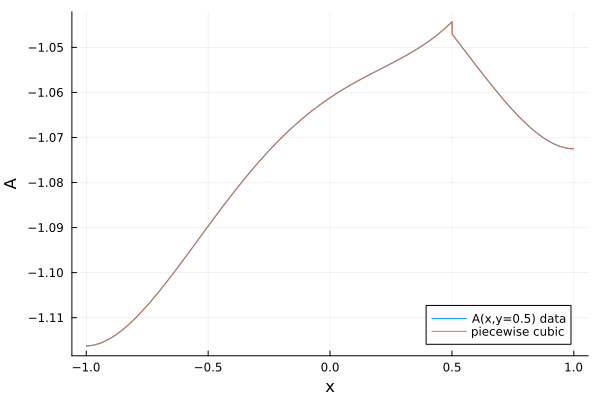

In [3]:
n = 2000
y_spike = 0.5
x_grid = LinRange(-1, 1, n+1)
x_inner = x_grid[2:end-1]

K_lr = greens(n, y_spike)[2:end-1]

i_x = argmin(abs.(x_grid.-y_spike))

G_vec_l = [analytic_G(xi, y_spike) for xi in x_inner[1:i_x]]
G_vec_r = [analytic_G(xi, y_spike) for xi in x_inner[i_x+1:end]]

A_vec_l = K_lr[1:i_x] ./ G_vec_l
A_vec_r = K_lr[i_x+1:end] ./ G_vec_r


p = 4
Vₗ = hcat([x_inner[1:i_x] .^ k for k in 0:p]...)
Vᵣ = hcat([x_inner[i_x+1:end] .^ k for k in 0:p]...)

cₗ = Vₗ \ A_vec_l
cᵣ = Vᵣ \ A_vec_r

fitAₗ(x) = sum(cₗ[k+1]*x^k for k in 0:p)
fitAᵣ(x) = sum(cᵣ[k+1]*x^k for k in 0:p)

plot(x_inner, [A_vec_l; A_vec_r], label="A(x,y=0.5) data", xlabel="x", ylabel="A")
plot!(x_inner, [fitAₗ.(x_inner[1:i_x]); fitAᵣ.(x_inner[i_x+1:end])], label="piecewise cubic", legend=:bottomright)




## 2D

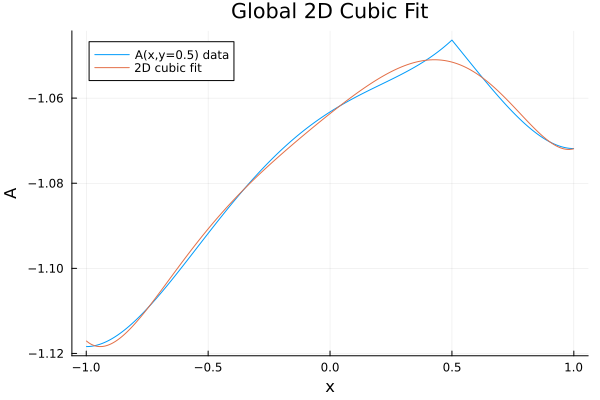

In [ ]:
using LinearAlgebra, Plots, SparseArrays

# Updated greens function
function greens(n::Int, y_spike::Float64)
    x_full = LinRange(-1, 1, n+1) # full grid
    x_in   = x_full[2:end-1] # interior grid
    h      = step(x_full)

    # finite-difference operator
    Z = x_in .^ 2
    T = SymTridiagonal(
        ones(n-1) .* (-2/h^2 .+ Z),
        ones(n-2) .* (1/h^2)
    )

    # RHS delta spike at y_spike
    f = zeros(n-1)
    i_y = argmin(abs.(x_in .- y_spike))
    f[i_y] = 1/h

    # solve and add zero boundary conditions
    u = T \ f
    return [0.0; u; 0.0]
end

# grids
n = 2000
m = n + 1
x_full  = LinRange(-1, 1, m)
x_inner = x_full[2:end-1]
y_full  = x_full
y_inner = y_full[2:end-1]

# Sample A(x_j,y_k) = K/G on the interior mesh
N = length(x_inner)
M = length(y_inner)
A_mat = zeros(N, M)

function analytic_G(x,y)
    if x ≤ y
        return 0.5*(1-y)*(1+x)
    else
        return 0.5*(1+y)*(1-x)
    end
end

for (k, y0) in enumerate(y_inner)
    K_full      = greens(n, y0)
    K_vec       = K_full[2:end-1]
    G_vec       = [analytic_G(xi, y0) for xi in x_inner]
    A_mat[:,k]  = K_vec ./ G_vec
end

# Build 1D Vandermondes of degree p
p  = 6
Vx = hcat([x_inner .^ k for k in 0:p]...)  # N × (p+1)
Vy = hcat([y_inner .^ k for k in 0:p]...)  # M × (p+1)

# Form the 2D Vandermonde via Kronecker and solve the global least-squares
V2d = kron(Vy, Vx)           # (N*M) × ((p+1)^2)
f_vec = vec(A_mat)            # length N*M
a = V2d \ f_vec           # length (p+1)^2 coefficients

# Build the fitted bivariate polynomial function
function A_fit(x, y)
    s, idx = 0.0, 1
    for j in 0:p
        for i in 0:p
            s   += a[idx] * x^i * y^j
            idx += 1
        end
    end
    return s
end

# check on the y=0.5 slice
y0   = 0.5
col  = findfirst(z -> isapprox(z, y0; atol=1e-6), y_inner)
A_data = A_mat[:, col]

plot(x_inner, A_data, label="A(x,y=0.5) data")
plot!(x_inner, A_fit.(x_inner, y0), label="2D cubic fit")
xlabel!("x"); ylabel!("A"); title!("Global 2D Cubic Fit")


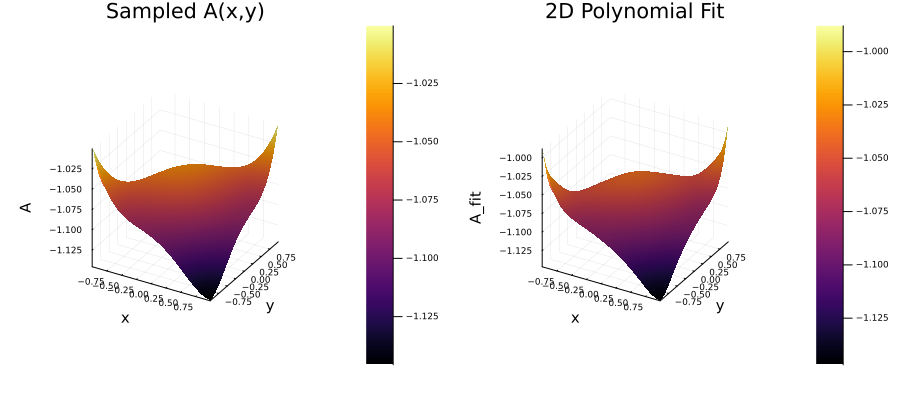

In [55]:
using Plots

# Build matrices of z‐values for plotting:

Z_data = A_mat'

# Evaluate fitted polynomial on the same grid
Z_fit = [ A_fit(xi, yj) for yj in y_inner, xi in x_inner ]

# Plot surface comparisons
plot(
    layout    = (1,2),
    size      = (900,400),
    xtickfont = font(6),
    ytickfont = font(6),
    ztickfont = font(6),
    guidefont = font(10)
)

surface!(
    x_inner, y_inner, Z_data;
    subplot = 1,
    title   = "Sampled A(x,y)",
    xlabel  = "x", ylabel="y", zlabel="A",
    legend  = false
)

surface!(
    x_inner, y_inner, Z_fit;
    subplot = 2,
    title   = "2D Polynomial Fit",
    xlabel  = "x", ylabel="y", zlabel="A_fit",
    legend  = false
)
